# Deliberation

In [302]:
import numpy as np
import random
import math
from scipy.stats import beta
import networkx as nx
import pandas as pd

from mesa import Model, Agent
from mesa.space import NetworkGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import mpmath 
from mpmath import mp
mp.prec = 100
sns.set()
from tqdm.notebook import tqdm
from itertools import starmap
from multiprocess import Pool, cpu_count

matplotlib.rcParams['figure.figsize'] = (9, 6)


## Evaluation Group Decision Methods

There are three types of criteria that can be used to  evaluate a proposed decision-making procedure: 

1. Practical reasons: The procedure should be easy to underst, eaasy to implement for groups of a given size, and following the procedure should not take too much time to arrive at a decision. 
2. Procedural reasons: The procedure should  should be fair and it should end up in a consensus that all group members endorse. 
3. Epistemic reasons: The group decision should be reliable and it should coincide with the fact of the matter if it is the task of the group to decide on a fact of the matter (e.g. the group decision should be 'guilty' if and only if the defendant is guilty).

No single procedure does best on all three criteria.   E.g., there are good epistemic reasons to use majority rule (cf. the Condorcet Jury Theorem), but there may not be consensus about the majority opinion.   How does *deliberation* compare to majority rule or other group-decision methods? 


This section presents the Bayesian model of deliberation from: 

S. Hartmann and S. Rafiee Rad (2018). [Voting, deliberation and truth](https://link.springer.com/content/pdf/10.1007%2Fs11229-016-1268-9.pdf), Synthese, 105, pp. 1273 - 1293. 


The provide a formal analysis which (i) shows that deliberation procedures are truth-conducive (in a similar way as majority voting is truth conducive according to the Condorcet Jury Theorem) and that (ii) explores under what conditions deliberation has a higher probabiliity than majority rule of identifying the correct outcome.


Fix a binary propositional variable with values $H$ meaning that the hypothesis is true, and $\neg H$ meaning that  the hypothesis is false.  For simplicity, we assume that $H$ is true. 

Consider a group of $n$ agents who deliberate on the truth or falsity of $H$. 

Each group members expresses an opinion about $H$ in terms of a yes/no vote.   The votes are represented by binary propositional variables $V_i$ (for $i = 1,\ldots, n$) with the values: $V_i$ meaning that agent $i$ votes "yes" (i.e., agent $i$ votes that $H$ is true) and $\neg V_i$ meaning that agent $i$ votes "no" (i.e., agent $i$ votes that $H$ is false).

Assume that it is in the interest of each group member that the probability that the ﬁnal verdict of the group corresponds to the truth is as large as possible (so there is no strategic voting).


## First Order  and Second Order Reliability

Each group member $i$ has a **first order reliability $r_i$**: the probability that $i$ will make  correct judgements. 

The agents do not know the reliability of the other agents, but they can estimate it:  At stage $t$, let 
$$r_{ij}^t = Pr^t_i(V_j\mid H) = Pr^t_i(\neg V_j\mid \neg H)$$
be $i$'s estimation of $j$'s first-order reliability. 

Each group member $i$ has a **second order reliability $c_i$** representing how well agent $i$ estimates the first order reliability of the other agents. If $c_i = 1$, then $i$ assigns the correct first order reliability to every group member $j$; and if $c_i = 0$, then $i$ assigns a random first-order reliability to the other agents drawn uniformly from $(0,1)$.


### Estimating first order reliabilities

To estimate a first order reliability $r_j$, with second order reliability $c_i$, agent $i$ draws from a beta distribution with: 

$$a=2\qquad b= \frac{\min(1, r_j - c_i + 1) - \max(0, r_j + c_i - 1)}{r_j - \max(0, r_j + c_i -1)}$$

in which $[0,1]$ is linearly transfered to the interval $[\max(0, r_j + c_i - 1), \min(1, r_j - c_i -1)]$

In [303]:
def find_beta(r, c):
    return 2, (min(1, r - c + 1) - max(0, r + c - 1)) / (r - max(0, r + c - 1))

def linear_transform(x, r, c): 
    max_x = min(1, r - c + 1)
    min_x = max(0, r + c - 1)
    return (max_x - min_x)* x + min_x

In [304]:
def estimate_reliability(rel, second_order_rel): 
    
    if second_order_rel == 0: 
        return np.random.uniform(0,1)
    elif second_order_rel == 1:
        return rel
    else: 
        return linear_transform(np.random.beta(*find_beta(rel, second_order_rel)), rel, second_order_rel)

A second way of estimating that is a bit easier is to draw uniformly from the interval  $[\max(0, r_j + c_i - 1), \min(1, r_j - c_i -1)]$. 

In [305]:
def estimate_reliability2(rel, second_order_rel): 
    
    return np.random.uniform(max(0, rel + second_order_rel -1), min(1, rel - second_order_rel + 1))


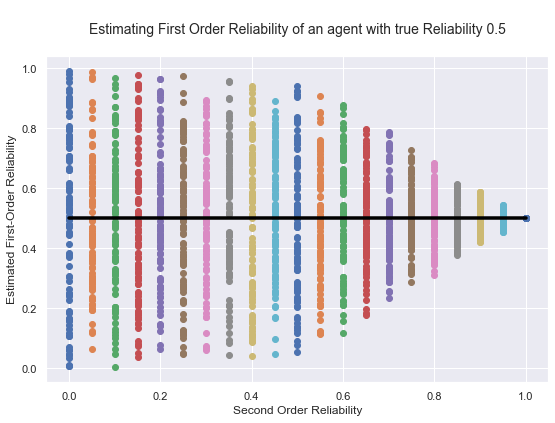

In [306]:
xs = np.linspace(0,1,1000)

rel = 0.5
for c in cs: 
    est_rels = [estimate_reliability(rel, c) for _ in range(100)]

    plt.scatter([c]*100, est_rels)
plt.ylabel("Estimated First-Order Reliability")
plt.xlabel("Second Order Reliability")

plt.title(f"\nEstimating First Order Reliability of an agent with true Reliability {rel}\n", fontsize=14)
plt.plot([0,1.0],[rel, rel],  '-', color="black",lw = 3.5);

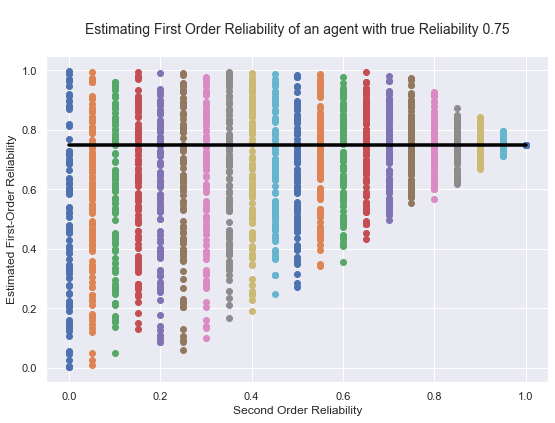

In [307]:
xs = np.linspace(0,1,1000)

rel = 0.75
for c in cs: 
    est_rels = [estimate_reliability(rel, c) for _ in range(100)]

    plt.scatter([c]*100, est_rels)
plt.ylabel("Estimated First-Order Reliability")
plt.xlabel("Second Order Reliability")

plt.title(f"\nEstimating First Order Reliability of an agent with true Reliability {rel}\n", fontsize=14)
plt.plot([0,1.0],[rel, rel],  '-', color="black",lw = 3.5);

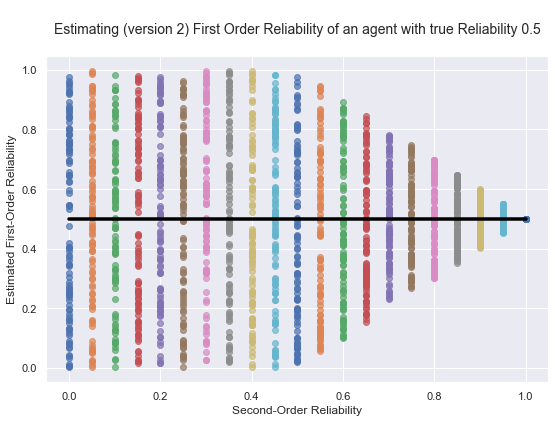

In [308]:
xs = np.linspace(0,1,1000)

rel = 0.5

for c in cs: 
    est_rels = [estimate_reliability2(rel, c) for _ in range(100)]

    plt.scatter([c]*100, est_rels, alpha=0.7)

plt.plot([0,1.0],[rel, rel],  '-', color="black",lw = 3.5)
plt.ylabel("Estimated First-Order Reliability")
plt.xlabel("Second-Order Reliability")
plt.title(f"\nEstimating (version 2) First Order Reliability of an agent with true Reliability {rel}\n", fontsize=14)
plt.show()

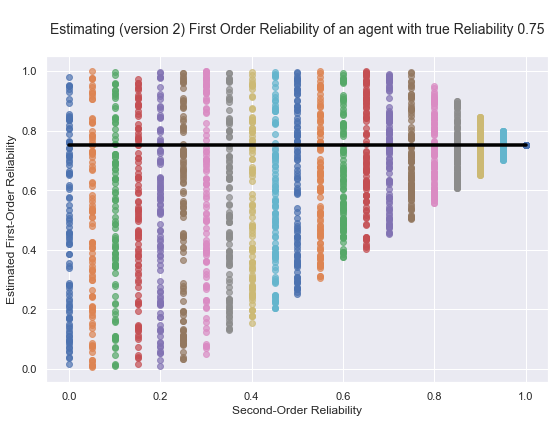

In [309]:
xs = np.linspace(0,1,1000)

rel = 0.75

for c in cs: 
    est_rels = [estimate_reliability2(rel, c) for _ in range(100)]

    plt.scatter([c]*100, est_rels, alpha=0.7)

plt.plot([0,1.0],[rel, rel],  '-', color="black",lw = 3.5)
plt.ylabel("Estimated First-Order Reliability")
plt.xlabel("Second-Order Reliability")
plt.title(f"\nEstimating (version 2) First Order Reliability of an agent with true Reliability {rel}\n", fontsize=14)
plt.show()

### Improving second order reliability 

The agents become better and better in assessing the reliability of the other group members.   The second order reliability $c_i^k$ is round $k$ increases linearly as a function of the number of rounds until a maximum value of $C_i\le 1$ is reached after $M$ rounds.   Afterwards, the second order reliability is constant: 

Let $c_i^0$ be the initial second order reliability, $C_i$ the maximum reliability for $i$ and $M$ is the maximum number of rounds.  Then, the second order reliability at round $k$ is: 

$$c_i^k = \begin{cases} (C_i - c_i^0) \cdot k/M + c_i^0 & 0\le k\le M\\
C_i & k>M\end{cases}$$


In [310]:
def updated_second_order_reliability(int_rel2, round_num, max_rel2, max_num_rounds):
    
    return (((max_rel2 - int_rel2) * round_num / max_num_rounds) + int_rel2) if round_num <= max_num_rounds else max_rel2
    

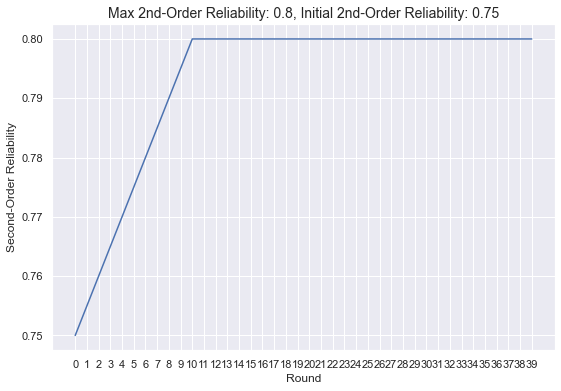

In [311]:
num_rounds = 40

max_num_rounds = 10
init_rel2 = 0.75
max_rel2 = 0.8

plt.plot([str(r) for r in range(num_rounds)], 
         [updated_second_order_reliability(init_rel2, r, max_rel2, max_num_rounds) for r in range(num_rounds)]);

plt.xlabel("Round")
plt.ylabel("Second-Order Reliability")
plt.title(f"Max 2nd-Order Reliability: {max_rel2}, Initial 2nd-Order Reliability: {init_rel2}", fontsize=14)
plt.show()

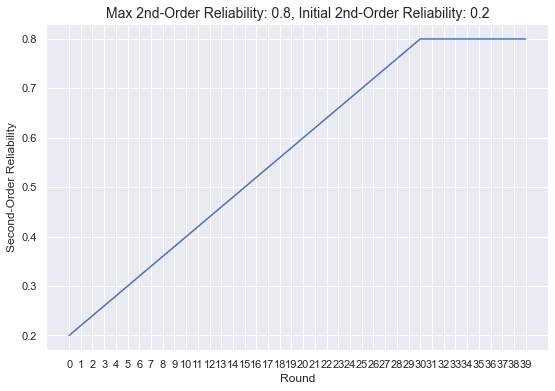

In [312]:
num_rounds = 40

max_num_rounds = 30
init_rel2 = 0.2
max_rel2 = 0.8

plt.plot([str(r) for r in range(num_rounds)], 
         [updated_second_order_reliability(init_rel2, r, max_rel2, max_num_rounds) for r in range(num_rounds)]);

plt.xlabel("Round")
plt.ylabel("Second-Order Reliability")
plt.title(f"Max 2nd-Order Reliability: {max_rel2}, Initial 2nd-Order Reliability: {init_rel2}", fontsize=14)
plt.show()

### Updating beliefs

Using the reliability estimates, the group members update their beliefs given how everyone votes  $(V_1^k, V_2^k,\ldots, V_n^k)$ in round $$.   

Each group member $i$ calculates the likelihood ratios at round $k$: 
$$x_{ij}^k = \frac{1-r_{ij}^k}{r_{ij}^t}$$

Then, $i$ updates $i$'s belief at round $k$, $Pr_i^k$ as follows: 

$$Pr_i^{k+1}(H) = Pr_i^k(H\mid V_1^k, \ldots, V_{i-1}^k, V_{i+1}^k, \ldots, V_n^{k})$$
 $$= \frac{Pr_i^k(H)}{Pr_i^k(H) + (1-Pr_i^k(H))\Pi_{j\ne i}(x^k_{ij})^{p_j}}$$
 where $p_j = 1$ if $V_j$ and $p_j=-1$ otherwise.


For example, let $\vec{V} = (1,0, 1, 1)$ be everyone's vote at round $k$ (where $1$ means "yes" and $0$ means "no") and suppose we want to determine agent $3$'s belief $Pr_3^{k+1}$.  Then, we have: 

$P_3^k(V_1\mid H) = r^k_{31}$

$P_3^k(V_2\mid H) = (1-r^k_{32})$

$P_3^k(V_4\mid H) = r^k_{34}$

$P_3^k(V_1\mid \neg H) = (1 - r^k_{31})$

$P_3^k(V_2\mid \neg H) = r^k_{32}$

$P_3^k(V_4\mid \neg H) = (1 - r^k_{34})$

Applying Bayes Theorem, we have: 

$$P_3^{k+1}(H) = P^{k}_3(H\mid V_1,V_2,V_3,V_4) = P_3^k(V_1, V_2,V_4\mid H)\frac{P_3^k(H)}{P_3^k(V_1,V_2,V_3)}$$

Then, we simplify $P_3^k(V_1, V_2,V_4\mid H)\frac{P_3^k(H)}{P_3^k(V_1,V_2,V_3)}$ as follows: 

$$\begin{eqnarray} 
 & = & P_3^k(V_1, V_2,V_4\mid H)\frac{P_3^k(H)}{P_3^k(H)P_3^k(V_1,V_2,V_3\mid H) + P_3^k(\neg H)P_3^k(V_1,V_2,V_3\mid \neg H)} \\
 & = &  P_3^k(V_1\mid H) P_3^k(V_2\mid H)P_3^k(V_4\mid H)\frac{P_3^k(H)}{P_3^k(H)P_3^k(V_1\mid H)P_3^k(V_2\mid H)P_3^k(V_3\mid H) + P_3^k(\neg H)P_3^k(V_1\mid \neg H)P_3^k(V_2\mid \neg H)P_3^k(V_3\mid \neg H)}\\
 & = & \frac{r^k_{31} (1-r^k_{32}) r^k_{34}P_3^k(H)}{P_3^k(H)r^k_{31} (1-r^k_{32}) r^k_{34} + (1-P_3^k(H))(1-r^k_{31}) r^k_{32}(1-r^k_{34})}\\
 & = & \frac{r^k_{31} (1-r^k_{32}) r^k_{34}P_3^k(H)}{P_3^k(H)r^k_{31} (1-r^k_{32}) r^k_{34} + (1-P_3^k(H))(1-r^k_{31}) r^k_{32}(1-r^k_{34})}\cdot\frac{1 /r^k_{31} (1-r^k_{32}) r^k_{34}}{1/r^k_{31} (1-r^k_{32}) r^k_{34}}\\
 & = & \frac{P_3^k(H)}{P_3^k(H) + (1-P_3^k(H))\frac{(1-r^k_{31}) r^k_{32}(1-r^k_{34})}{r^k_{31} (1-r^k_{32}) r^k_{34}}}\\
& = &\frac{P_3^k(H)}{P_3^k(H) + (1-P_3^k(H)) x_{31}^{p_1}x_{32}^{p_2}x^{p_3}_{34}}
 \end{eqnarray}$$
 


where $x_{3i}=\frac{1-r_{3i}}{r_{3i}}$ and $p_i=\begin{cases} 1 &\mbox{if } V_i\\
                                                               -1 & \mbox{if } \neg V_i\end{cases}$



### The deliberation procedure

1. Initially, each group member assigns some probability to $H$ (drawn from a uniform distribution over $(0,1)$. 
2. Each group member casts a vote on the basis of this probability (vote 1 if the probability of $H$ is $\ge 0.5$ and $0$ otherwise). 
3. Each group member updates her probability on the basis of the votes of the other group members, weighted according to the estimated reliabilities.
4. The second order reliabilities are increased each round leading to more accurate estimation of first order reliabilities. 
5. The procedure is iterated, and after a number of rounds, the process converges.


In [313]:
def find_beta(r, c):
    return 2, (min(1, r - c + 1) - max(0, r + c - 1)) / (r - max(0, r + c - 1))

def linear_transform(x, r, c): 
    max_x = min(1, r - c + 1)
    min_x = max(0, r + c - 1)
    return (max_x - min_x)* x + min_x

class Expert(Agent): 
    
    def __init__(self, unique_id, model, prior, rel, rel2, max_rel2, max_rounds):
        
        super().__init__(unique_id, model)
        self.pr = prior
        self.rel = rel
        self.init_rel2 = rel2
        self.rel2 = self.init_rel2
        self.max_rel2 = max_rel2
        self.max_rounds = max_rounds
        self.current_vote = self.vote()

    def vote(self):
        self.current_vote =  self.pr >= 0.5
        return self.current_vote
    
    def updated_second_order_reliability(self, d_round):

        return (((self.max_rel2 - self.init_rel2) * d_round / self.max_rounds) + self.init_rel2) if d_round <= self.max_rounds else self.max_rel2

    def estimate_reliability(self, j): 

        if self.rel2 == 0: 
            return np.random.uniform(0,1)
        elif self.rel2 == 1:
            return j.rel
        else: 
            return linear_transform(np.random.beta(*find_beta(j.rel, self.rel2)), j.rel, self.rel2)

    def estimate_reliability2(self, j): 

        return np.random.uniform(max(0, j.rel + self.rel2 - 1), min(1, j.rel - self.rel2 + 1))
    
    def bayes_update(self, v_profile):
        
        est_reliabilities = [self.estimate_reliability(j) for j in v_profile]
        #print("est_rel", est_reliabilities)
        likelihoods = [(1 - r) / r for r in est_reliabilities]
        exps = [1 if j.current_vote else -1 for j in v_profile]
        new_pr = self.pr / (self.pr + (1 - self.pr)*np.prod([r**e for r,e in zip(likelihoods, exps)]))
        self.pr = new_pr
        
class DeliberationModel(Model): 
    
    def __init__(self, 
                 num_experts, 
                 priors = None, 
                 rels = None, 
                 second_order_rels = None, 
                 max_second_order_rels = None,
                 max_rounds_for_rel2s = None):
        
        self.num_experts = num_experts
        self.schedule = RandomActivation(self)
        self.running = True
        
        for e_id in range(num_experts):
            prior = priors[e_id] if priors is not None else np.random.uniform(0,1)
            rel = rels[e_id] if rels is not None else 0.75
            rel2 = second_order_rels[e_id] if second_order_rels is not None else 0.6
            max_rel2 = max_second_order_rels[e_id] if max_second_order_rels is not None else 1.0
            max_rounds_for_rel2 = max_rounds_for_rel2s[e_id] if max_rounds_for_rel2s is not None else 20
            
            e = Expert(e_id, self, prior, rel, rel2, max_rel2, max_rounds_for_rel2)
            self.schedule.add(e)
            
        self.init_group_opinion = self.majority_vote()
        
    def majority_vote(self):
        return sum([e.current_vote for e in self.schedule.agents]) > self.num_experts / 2
    
    def consensus(self): 
        return all([e.current_vote for e in self.schedule.agents]) or all([not e.current_vote for e in self.schedule.agents]) 
    
    def consensus_opinion(self): 
        if self.consensus(): 
            return all([e.current_vote for e in self.schedule.agents]) 
        else: 
            return None
        
    def agreement_in_beliefs(self): 
        return all([math.fabs(self.schedule.agents[0].pr - e.pr) < 0.01 for e in self.schedule.agents])
    
    def prob_majority_correct(self, ev = True,  num_trials = 1000): 
        
        maj_correct = 0
        for t in range(num_trials): 
            votes = [random.random() < e.rel if ev else not(random.random() < e.rel) for e in self.schedule.agents]
            
            if ev and sum(votes) > self.num_experts / 2: 
                maj_correct += 1
            elif not ev and sum(votes) < self.num_experts / 2: 
                maj_correct += 1

        return maj_correct / num_trials
    
    def step(self, delib_round):
        
        # everyone votes
        for e in self.schedule.agents:
            e.vote()
            
        # each expert learns from the others
        for e in self.schedule.agents: 
            e.bayes_update([other_e for other_e in self.schedule.agents if other_e.unique_id != e.unique_id])

        # each expert updates their 2nd order reliability
        for e in self.schedule.agents: 
            e.updated_second_order_reliability(delib_round)
        
        if self.consensus() and delib_round > 1: 
            self.running = False
            

In [314]:
num_experts = 2
num_rounds = 6

priors = [0.4]*num_experts
rels = [0.4] * num_experts
second_order_rels = [1.0] * num_experts
max_second_order_rels = [1.0] * num_experts
max_rounds_for_rel2s = [5] * num_experts

dmodel = DeliberationModel(num_experts, 
                           priors = priors, 
                           rels = rels,
                           second_order_rels = second_order_rels, 
                           max_second_order_rels = max_second_order_rels,
                           max_rounds_for_rel2s = max_rounds_for_rel2s)

for e in dmodel.schedule.agents:
    print(f"{e.unique_id} pr is {e.pr}")
    print(f"\tvote is {e.vote()}")
print("\nInitial group opinion", dmodel.init_group_opinion)
print("Is there consensus? ", dmodel.consensus())
print("The consensus opinion is ", dmodel.consensus_opinion())
print("Is there agreement in beliefs? ", dmodel.agreement_in_beliefs())
print("The probability that the majority is correct: ", dmodel.prob_majority_correct())

print("\n\n")

r = 0 
while dmodel.running and r < num_rounds:
    dmodel.step(r)
    r+= 1

print(f"After {r} rounds: \n")

for e in dmodel.schedule.agents:
    print(f"{e.unique_id} pr is {e.pr}")
    print(f"\tvote is {e.vote()}")
    
print("\nInitial group opinion", dmodel.init_group_opinion)
print("Is there consensus? ", dmodel.consensus())
print("The consensus opinion is ", dmodel.consensus_opinion())
print("Is there agreement in beliefs? ", dmodel.agreement_in_beliefs())


0 pr is 0.4
	vote is False
1 pr is 0.4
	vote is False

Initial group opinion False
Is there consensus?  True
The consensus opinion is  False
Is there agreement in beliefs?  True
The probability that the majority is correct:  0.153



After 3 rounds: 

0 pr is 0.5
	vote is True
1 pr is 0.5
	vote is True

Initial group opinion False
Is there consensus?  True
The consensus opinion is  True
Is there agreement in beliefs?  True


In [315]:
num_experts = 9
num_rounds = 20

priors = None #[0.2, 0.55, 0.55, 0.55, 0.55] 
rels = [0.4] * num_experts
second_order_rels = [0.6] * num_experts
max_second_order_rels = [1.0] * num_experts
max_rounds_for_rel2s = [10] * num_experts

dmodel = DeliberationModel(num_experts, 
                           priors = priors, 
                           rels = rels,
                           second_order_rels = second_order_rels, 
                           max_second_order_rels = max_second_order_rels,
                           max_rounds_for_rel2s = max_rounds_for_rel2s)

for e in dmodel.schedule.agents:
    print(f"{e.unique_id} pr is {e.pr}")
    print(f"\tvote is {e.vote()}")
print("\nInitial group opinion", dmodel.init_group_opinion)
print("Is there consensus? ", dmodel.consensus())
print("The consensus opinion is ", dmodel.consensus_opinion())
print("Is there agreement in beliefs? ", dmodel.agreement_in_beliefs())
print("The probability that the majority is correct: ", dmodel.prob_majority_correct())

print("\n\n")

r = 0 
while dmodel.running and r < num_rounds:
    dmodel.step(r)
    r+= 1

print(f"After {r} rounds: \n")

for e in dmodel.schedule.agents:
    print(f"{e.unique_id} pr is {e.pr}")
    print(f"\tvote is {e.vote()}")
    
print("\nInitial group opinion", dmodel.init_group_opinion)
print("Is there consensus? ", dmodel.consensus())
print("The consensus opinion is ", dmodel.consensus_opinion())
print("Is there agreement in beliefs? ", dmodel.agreement_in_beliefs())


0 pr is 0.1429533812583108
	vote is False
1 pr is 0.39570873768201753
	vote is False
2 pr is 0.8230293109331983
	vote is True
3 pr is 0.6383229046146053
	vote is True
4 pr is 0.5052636235077791
	vote is True
5 pr is 0.8431869329948308
	vote is True
6 pr is 0.10512051354031182
	vote is False
7 pr is 0.04328977326553041
	vote is False
8 pr is 0.2474475797704352
	vote is False

Initial group opinion False
Is there consensus?  False
The consensus opinion is  None
Is there agreement in beliefs?  False
The probability that the majority is correct:  0.259



After 20 rounds: 

0 pr is 7.762887147733059e-06
	vote is False
1 pr is 0.9999967231405857
	vote is True
2 pr is 0.6758952273057038
	vote is True
3 pr is 0.9999999999999999
	vote is True
4 pr is 0.9731396406620192
	vote is True
5 pr is 1.799371955313458e-06
	vote is False
6 pr is 7.383912372921836e-07
	vote is False
7 pr is 0.9966096369199589
	vote is True
8 pr is 1.247914345184635e-14
	vote is False

Initial group opinion False
Is there 

## A Second Model of Deliberation

Another approach to modeling deliberation can be found in the following paper: 

H. Ding and M. Pivato (2021). [Deliberation and epistemic democracy](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3440612),  Journal of Economic Behavior and Organization, 185, pp. 138-167

### The agent/group opinions

* There is a set $N$ if agents.
* In the simplest setting, there are two states $1$ and $-1$ (one of which is the "true state" and the agents receive two types of evidence (positive evidence favoring $1$ and negative evidence favoring $-1$).  
* The true state is unknown.
* The agents receives informative signals of this state, i.e., the *evidence* which is either private or public.

For evidence $x$, let $y_x$ be the state that $x$ favors. 

Each agent has access to two sets of evidence at time $t$: 

1. $\mathcal{C}^t$ is common evidence at time $t$
2. $\mathcal{P}^t_i$ is $i$'s private evidence at time $t$

The **agent's opinion at time $t$** is calculated as follows: 

$$s_i^t = \mathrm{sgn}\left ( \sum_{c\in \mathcal{C}^t} y_c + \sum_{p\in\mathcal{P}_i^t} y_p\right )$$

Then, the **majority opinion at time $t$** is calculated as follows: 

$$Maj^t = \mathrm{sgn}\left (\sum_{i\in N} s_i^t\right )$$


### Evidence disclosure

During deliberation, agents *disclose* some of their private evidence, turning it into public evidence, to modify the beliefs of the other agents.   The key assumption is: 

* It is easy for agents to learn their peers’ opinions during each round of deliberation, simply by asking them yes/no questions or holding a straw vote. But it is not possible for agents to learn the underlying beliefs of their peers. (See Section 4 for a model with belief disclosure.) 
* It is diﬃcult to learn what evidence---or even how much evidence---their peers have to justify these opinions.
* An agent will not "disclose" their evidence (i.e. explain these facts and arguments) unless she has an incentive to do so. 
* Each agent wants the collective decision to be correct. At any time during deliberation, the agent believes that her current opinion is correct; thus, she seeks to persuade other group members to agree with her current opinion.   She will disclose evidence only if it advances this goal: 
    * She will only disclose evidence if her current opinion disagrees with the current collective decision (i.e., she **dissents** from the group)
    * Agents who already agree with the current collective decision will not disclose evidence, because such disclosure is costly, and they have no reason to incur this cost.




###  The deliberation protocol 

* Deliberation proceeds in a number of rounds $t=1, 2, 3, \ldots, T$
* In each round, new evidence is disclosed generating a sequence of public evidence
$$\mathcal{C}^1, \mathcal{C}^2, \ldots, \mathcal{C}^T$$
* This process must end in finite time, because there is only a finite amount of evidence. 
* When deliberation ends, all agents are silent, either because they have no evidence left to reveal, or they have no incentive to reveal their remaining evidence.  This is called a **deliberative equilibrium**.


Two protocols: 

1. The **serial protocol**:  only one dissenting agent (randomly chosen) speaks during each round of deliberation.
2. The **parallel protocol**: all dissenting agents can speak during each round of deliberation.


The **reliability of a majority decision** is the probability that it matches
the true state.'

There is **full disclosure** at time $t$ if all agents have complete information, i.e., $\mathcal{C}^t$ is the set of all evidence.  

**Proposition**. The majority decision under full disclosure achieves the maximum reliability possible given the available information.

Often  full disclosure is  unachievable.  Say a deliberative equilibrium is **full-disclosure equivalent** if its majority decision is the same as the one that would have been reached under full disclosure.


When is the deliberative equilibrium full-disclosure equivalent?


In [326]:
class Expert2(Agent):
    
    """Expert to vote on a single proposition.
     competence: float between 0 and 1"""
    def __init__(self, unique_id, model,  evidence):
        super().__init__(unique_id, model)
        self.evidence = evidence
        self.disclosed_evidence = list()
           
    def vote_personal_evidence(self): 
        return np.sign(np.sum(np.fromiter([1 if ev % 2 == 0 else -1 for ev in self.evidence], int)))
        
    def vote(self):
        all_evidence = list(set(self.evidence + self.model.evidence)) # don't double count evidence
        return np.sign(np.sum(np.fromiter([1 if ev % 2 == 0 else -1 for ev in all_evidence], int)))
    
    def is_silent(self): 
        '''return true if the agent is silent during this round'''
        ev_to_disclose = list()
        if self.vote() < self.model.maj_opinion: 
            # disclose negative evidence 
            # only disclose evidence you haven't already disclosed            
            ev_to_disclose = [e for e in self.evidence 
                              if e % 2 == 1 and e not in self.disclosed_evidence]
                        
        elif self.vote() > self.model.maj_opinion: 
            # disclose positive evidence
            # only disclose evidence you haven't already disclosed            
            ev_to_disclose = [e for e in self.evidence 
                              if e % 2 == 0 and e not in self.disclosed_evidence]
        
        return len(ev_to_disclose) == 0
    
    def disclose_evidence(self):
        
        ev_to_disclose = list()
        if self.vote() < self.model.maj_opinion: 
            # disclose negative evidence 
            # only disclose evidence you haven't already disclosed            
            ev_to_disclose = [e for e in self.evidence 
                              if e % 2 == 1 and e not in self.disclosed_evidence]
                        
        elif self.vote() > self.model.maj_opinion: 
            # disclose positive evidence
            # only disclose evidence you haven't already disclosed            
            ev_to_disclose = [e for e in self.evidence 
                              if e % 2 == 0 and e not in self.disclosed_evidence]

        if len(ev_to_disclose) > 0: 
            ev = random.choice(ev_to_disclose)
            self.disclosed_evidence.append(ev)
        else: 
            ev = None
        return ev
    
class DeliberationModel(Model):

    def __init__(self, N, potential_evidence, delib_protocol, gen_prob,  num_options=2, seed = None):
        self.num_experts = N
        
        self.delib_protocol = delib_protocol
        self.schedule = RandomActivation(self)
        
        # generate evidence probs
        ev_probs = np.random.default_rng().dirichlet((1,)* len(potential_evidence), 1)[0]
        
        # define the public evidence
        amount_of_evidence = random.choice(range(len(potential_evidence)))
        self.evidence = list(np.random.choice(potential_evidence, amount_of_evidence, replace=False,  p=ev_probs))       
        self.maj_opinion = None
        
        self.deliberation_round = 0
        all_agent_evidence = list()
        # Create experts
        self.current_agent_index = 0
        
        for i in range(self.num_experts):
            amount_of_evidence = random.choice(range(len(potential_evidence)))
            agent_ev = list(np.random.choice(potential_evidence, amount_of_evidence, replace=False,  p=ev_probs))      
            
            a = Expert2(i, self,  agent_ev)
            self.schedule.add(a) 
            
            all_agent_evidence += agent_ev
        
        all_evidence = list(set(self.evidence + all_agent_evidence))
        self.correct = np.sign(np.sum(np.fromiter([1 if e % 2 == 0 else -1 for e in all_evidence], int)))
        
        self.set_num_neutral_agents()
        self.group_vote()
        self.running = True
        
        self.datacollector = DataCollector(
            model_reporters={"maj_opinion_correct": lambda m: m.maj_opinion == m.correct,
                             "num_neutral_agents": lambda m: m.num_neutral_agents,
                             "num_correct": lambda m: len([a for a in self.schedule.agents if a.vote() == m.correct])})
        
    
    def set_num_neutral_agents(self): 
        self.num_neutral_agents = len([a for a in self.schedule.agents if a.vote_personal_evidence() == 0])

    def group_vote(self):
        
        # determine the majority opinion by majority vote
        self.maj_opinion = np.sign(np.sum(np.fromiter([a.vote() for a in self.schedule.agents], int)))
        
    def is_deliberation_equilibrium(self):
        return all([a.is_silent() for a in self.schedule.agents])
        
    def step(self): 
        
        # fix the group opinion
        self.group_vote()
        
        if self.delib_protocol == "Serial":
            
            # choose a random agent
            a = self.random.choice(self.schedule.agents)
            ev = a.disclose_evidence()
            if ev is not None:
                self.evidence.append(ev)
            self.deliberation_round += 1

        else: 
            
            evidence_shared = False
        
            for a in self.schedule.agents: 
                ev = a.disclose_evidence()
                if ev is not None:
                    self.evidence.append(ev)
            self.deliberation_round += 1
        
        self.set_num_neutral_agents()

        self.running = not self.is_deliberation_equilibrium()  
        self.datacollector.collect(self)
        

A deliberation equilibrium will not necessarily result in consensus: 

In [327]:
potential_evidence = [2, 4, 6, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]

N=5
delib_protocol = "Parallel"
max_delib_rounds = len(potential_evidence) + 5
dmodel = DeliberationModel(N, potential_evidence, delib_protocol, None, num_options=2)

dmodel.evidence = []
dmodel.schedule.agents[0].evidence = [2]
dmodel.schedule.agents[1].evidence = [4, 6, 1]
dmodel.schedule.agents[2].evidence = [3, 5, 7, 9]
dmodel.schedule.agents[3].evidence = [11, 13, 15, 17]
dmodel.schedule.agents[4].evidence = [19, 21, 23, 25]
dmodel.correct = np.sign(np.sum(np.fromiter([1 if e % 2 == 0 else -1 for e in all_ev], int)))
dmodel.num_neutral_agents = len([a for a in dmodel.schedule.agents 
                                 if a.vote_personal_evidence() == 0])
dmodel.running = True
print("\nAll evidence", potential_evidence)
print("The true state is", dmodel.correct, "\n")
while dmodel.running and dmodel.deliberation_round < max_delib_rounds: 
    dmodel.step()
    for a in dmodel.schedule.agents:
        print(f"{a.unique_id} vote is", a.vote())
        print(f"\tvote based on personal evidence is", a.vote_personal_evidence())
        print(f"\tpersonal evidence is", a.evidence)
        print(f"\tdisclosed evidence is", a.disclosed_evidence)
    print("Public evidence ", dmodel.evidence)
    print("Number of neutral agents", dmodel.num_neutral_agents)
    print("Majority opinion ", dmodel.maj_opinion)
    print("Deliberation round ", dmodel.deliberation_round)
    print("")


All evidence [2, 4, 6, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
The true state is -1 

0 vote is 1
	vote based on personal evidence is 1
	personal evidence is [2]
	disclosed evidence is [2]
1 vote is 1
	vote based on personal evidence is 1
	personal evidence is [4, 6, 1]
	disclosed evidence is [4]
2 vote is -1
	vote based on personal evidence is -1
	personal evidence is [3, 5, 7, 9]
	disclosed evidence is []
3 vote is -1
	vote based on personal evidence is -1
	personal evidence is [11, 13, 15, 17]
	disclosed evidence is []
4 vote is -1
	vote based on personal evidence is -1
	personal evidence is [19, 21, 23, 25]
	disclosed evidence is []
Public evidence  [2, 4]
Number of neutral agents 0
Majority opinion  -1
Deliberation round  1

0 vote is 1
	vote based on personal evidence is 1
	personal evidence is [2]
	disclosed evidence is [2]
1 vote is 1
	vote based on personal evidence is 1
	personal evidence is [4, 6, 1]
	disclosed evidence is [4, 6]
2 vote is -1
	vote based on personal 

In [335]:
N=10
potential_evidence = range(5)
delib_protocol = "Parallel"
max_delib_rounds = len(potential_evidence) + 5
dmodel = DeliberationModel(N, potential_evidence, delib_protocol, None, num_options=2)

print("\nAll evidence", potential_evidence)
print("The true state is", dmodel.correct, "\n")
while dmodel.running and dmodel.deliberation_round < max_delib_rounds: 
    dmodel.step()
    for a in dmodel.schedule.agents:
        print(f"{a.unique_id} vote is", a.vote())
        print(f"\tvote based on personal evidence is", a.vote_personal_evidence())
        print(f"\tpersonal evidence is", a.evidence)
        print(f"\tdisclosed evidence is", a.disclosed_evidence)
    print("Public evidence ", dmodel.evidence)
    print("Number of neutral agents", dmodel.num_neutral_agents)
    print("Majority opinion ", dmodel.maj_opinion)
    print("Deliberation round ", dmodel.deliberation_round)
    print("")


All evidence range(0, 5)
The true state is 1 

0 vote is 0
	vote based on personal evidence is 1
	personal evidence is [3, 0, 2]
	disclosed evidence is []
1 vote is 0
	vote based on personal evidence is 1
	personal evidence is [1, 0, 2]
	disclosed evidence is [1]
2 vote is -1
	vote based on personal evidence is 1
	personal evidence is [2]
	disclosed evidence is []
3 vote is 1
	vote based on personal evidence is 1
	personal evidence is [4, 0]
	disclosed evidence is []
4 vote is 0
	vote based on personal evidence is 1
	personal evidence is [2, 0, 3]
	disclosed evidence is [3]
5 vote is 0
	vote based on personal evidence is 1
	personal evidence is [3, 4, 2]
	disclosed evidence is [3]
6 vote is -1
	vote based on personal evidence is -1
	personal evidence is [3]
	disclosed evidence is [3]
7 vote is 0
	vote based on personal evidence is 1
	personal evidence is [0, 3, 2]
	disclosed evidence is [3]
8 vote is 0
	vote based on personal evidence is 1
	personal evidence is [0, 2, 3]
	disclosed ev

## Further Reading

1. S. Hartmann and S. Rafiee Rad (2020). [Anchoring in Deliberations](http://philsci-archive.pitt.edu/15015/14/Anchoring_Final_Archive.pdf), Erkenntnis 85, pp. 1041 - 1069. 

2. G. Butler, G. Pigozzi and J. Rouchier (2019). [Mixing Dyadic and Deliberative Opinion Dynamics in an Agent-Based Model of Group Decision-Making](https://downloads.hindawi.com/journals/complexity/2019/3758159.pdf), Complexity, Volume 2019, Article ID 3758159.